# Investigate prior of moments for frequent actions / objects

In [1]:
cd ../../

/mnt/sda/otani/Experiments/moment_retrieval


In [18]:
%matplotlib inline
from typing import List
import pandas as pd
import numpy as np
import spacy
import matplotlib.pyplot as plt
from src.toolbox.utils import _nms, sentence2token, _load_top_actions
from src.toolbox.eval import evaluate, location_error, accumulate_metrics, categorize_results, summarize_results_per_class, predict
from src.toolbox.visualization import plot_performance_per_class, plot_performance_per_duration
from src.toolbox.data_converters import Charade2Instances
from src.toolbox.baseline import SegmentGeneratorKDE
import seaborn as sns
sns.set_style("white")

In [16]:
def get_key_tokens(sentences: List[str]):
    simplified_sentences = []

    for i, sentence in enumerate(sentences):
        key_tokens = sentence2token(sentence)
        simplified_sentences.append(key_tokens)
        
    return simplified_sentences

In [17]:
train_data = Charade2Instances(pd.read_csv('data/processed/train.csv'))
sentences = [query[1] for query, _ in train_data]
simplified_sentences = get_key_tokens(sentences)

for i, item in enumerate(simplified_sentences):
    q = " -- ".join(sum(item, []))
    print(q)
    if i > 15:
        break

put -- book -- shelf
begin -- play -- phone
start -- play -- phone
pour -- glass
pour -- water -- glass
pour -- water -- glass
start -- watch -- television
take -- cup -- fridge
sneeze -- mirror
awaken
hold -- mirror
play -- camera
sit -- sneeze -- computer
start -- sneeze
notebook -- bag
start -- sneeze
open -- door


# show top actions

0.9320226349390598

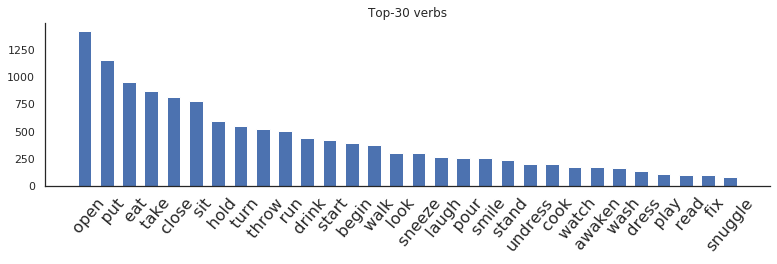

In [19]:
from collections import Counter

verbs = sum([x[0] for x in simplified_sentences], [])
verb_c = Counter(verbs)
k = 30

counts = [v for _, v in verb_c.most_common(k)]
top_actions = [word for word, _ in verb_c.most_common(k)]
max_l = max([len(word) for word in top_actions])
strech = 1.3

padded_top_actions = [" "*(max_l - len(word))+word for word in top_actions]
plt.figure(figsize=(13, 3))
plt.bar(np.arange(len(counts))*strech, counts)
_ = plt.xticks(np.arange(len(counts))*strech, padded_top_actions, rotation=50, fontsize=16)
plt.title(f"Top-{k} verbs")
plt.gca().grid(False)
sns.despine()
plt.savefig("reports/figures/dataset visualization/Charade-STR_top-verbs.pdf", bbox_inches="tight")
sum(counts)/sum(verb_c.values())

# show top objects

0.7227801107662346

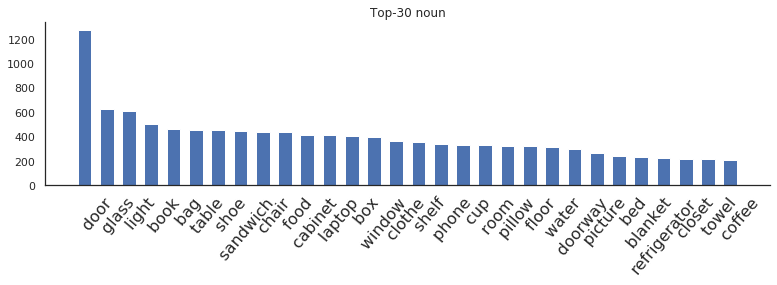

In [20]:
nouns = sum([x[1] for x in simplified_sentences], [])
noun_c = Counter(nouns)
k = 30

counts = [v for _, v in noun_c.most_common(k)]
top_objs = [word for word, _ in noun_c.most_common(k)]
max_l = max([len(word) for word in top_objs])
strech = 1.3

top_objs = [" "*(max_l - len(word))+word for word in top_objs]
plt.figure(figsize=(13, 3))
plt.bar(np.arange(len(counts))*strech, counts)
_ = plt.xticks(np.arange(len(counts))*strech, top_objs, rotation=50, fontsize=16)
plt.title(f"Top-{k} noun")
plt.gca().grid(False)
sns.despine()
plt.savefig("reports/figures/dataset visualization/Charade-STR_top-nouns.pdf", bbox_inches="tight")
# plt.figure(figsize=(13, 3))
# plt.bar(range(len(counts)), counts)
# _ = plt.xticks(range(len(counts)), top_objs, rotation=45, fontsize=12)
# plt.title(f"Top-{k} noun vocabulary (/{len(noun_c)})")

sum(counts)/sum(noun_c.values())

In [21]:
blind_segment_generator = SegmentGeneratorKDE()
blind_segment_generator.fit("base", train_data)

#instances: 12408


In [22]:
segment_generator = SegmentGeneratorKDE()
for action in top_actions:
    indices = [i for i, query in enumerate(simplified_sentences) if action in query[0]]
    sub_train = [train_data[i] for i in indices]
    segment_generator.fit(action, sub_train)
segment_generator.fit("base", train_data)

for action, kernel in segment_generator.kernels.items():
    X, Y = np.mgrid[0:1:100j, 0:1:100j]
    positions = np.vstack([X.ravel(), Y.ravel()])
    Z = np.reshape(kernel(positions).T, X.shape)
    plt.imshow(np.rot90(Z), cmap=plt.cm.GnBu, extent=[0, 1, 0, 1])
    plt.title(action, fontsize=14)
    plt.gca().grid(False)
    plt.savefig(f"reports/figures/density estimation/charade/{action}.pdf", bbox_inches="tight")
    plt.show()

#instances: 1421
#instances: 1154
#instances: 949
#instances: 870
#instances: 810
#instances: 780
#instances: 591
#instances: 545
#instances: 523
#instances: 504
#instances: 439
#instances: 419
#instances: 395
#instances: 378
#instances: 306
#instances: 297
#instances: 266
#instances: 258
#instances: 256
#instances: 239
#instances: 204
#instances: 202
#instances: 176
#instances: 173
#instances: 161
#instances: 139
#instances: 105
#instances: 103
#instances: 102
#instances: 78
#instances: 12408


# Test action prior

In [23]:
test_data = Charade2Instances(pd.read_csv("data/processed/test.csv"))

In [10]:
# action-agnostic baseline
action_agnostic_predictions = predict(blind_segment_generator, test_data, 0.45)
action_agnostic_results = evaluate(test_data, action_agnostic_predictions)
action_agnostic_summary = accumulate_metrics(action_agnostic_results)
f"{action_agnostic_summary['R@1 IoU>0.5'] * 100:.2f}"

R@1 IoU>0.3 0.36
R@1 IoU>0.5 0.23
R@1 IoU>0.7 0.09
R@5 IoU>0.3 0.89
R@5 IoU>0.5 0.67
R@5 IoU>0.7 0.27
R@10 IoU>0.3 1.00
R@10 IoU>0.5 0.91
R@10 IoU>0.7 0.44


In [24]:
# use only first seen verb
predictions = predict(segment_generator, test_data, 0.45)
results = evaluate(test_data, predictions)
summary = accumulate_metrics(results)
f"{summary['R@1 IoU>0.5'] * 100:.2f}"

R@1 IoU>0.3 0.41
R@1 IoU>0.5 0.28
R@1 IoU>0.7 0.11
R@5 IoU>0.3 0.87
R@5 IoU>0.5 0.73
R@5 IoU>0.7 0.36
R@10 IoU>0.3 1.00
R@10 IoU>0.5 0.94
R@10 IoU>0.7 0.48


'28.28'

In [31]:
import pickle as pkl
pkl.dump(results,
    open("reports/figure_src/results/charade/blind(action).pkl", "wb"))

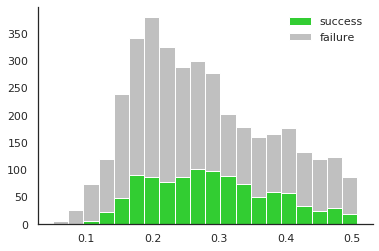

In [29]:
from src.toolbox.visualization import plot_performance_per_duration

plt.rcParams.update({'font.size': 14})
fig = plot_performance_per_duration(results, test_data)
plt.savefig("reports/figures/detailed_analysis/charade/performance_per_duration/blind(action).pdf", bbox_inches="tight")

# Temporal location error

The drop around 0 is due to the removal of success instances.

Text(0.5, 1.0, 'end error')

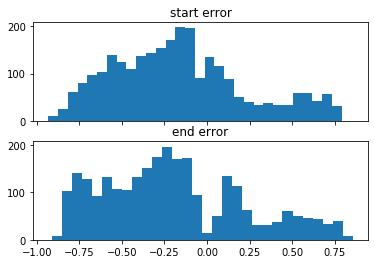

In [16]:
errors = location_error(test_data, results)
start_error = [error[0] for _, error in errors]
end_error = [error[1] for _, error in errors]

f, axes = plt.subplots(2, 1, sharex=True, sharey=True)
axes[0].hist(start_error, bins=30)
axes[0].set_title("start error")
axes[1].hist(end_error, bins=30)
axes[1].set_title("end error")

In [21]:
metrics = []
for nms_thresh in np.linspace(0.4, 0.6, 10):
    predictions = predict(segment_generator, test_data, nms_thresh)
    results = evaluate(test_data, predictions)
    summary = accumulate_metrics(results)
    metrics.append(summary)

/mnt/sda/otani/Experiments/moment_retrieval/src/toolbox/utils.py:48: RuntimeWarning: invalid value encountered in true_divide
  ovr = inter / (lengths[i] + lengths[order[1:]] - inter)
/mnt/sda/otani/Experiments/moment_retrieval/src/toolbox/utils.py:49: RuntimeWarning: invalid value encountered in less_equal
  inds = np.where(ovr <= thresh)[0]


1000
2000
3000
R@1 IoU>0.3 0.42
R@1 IoU>0.5 0.28
R@1 IoU>0.7 0.12
R@5 IoU>0.3 0.89
R@5 IoU>0.5 0.74
R@5 IoU>0.7 0.34
R@10 IoU>0.3 1.00
R@10 IoU>0.5 0.91
R@10 IoU>0.7 0.43
1000
2000
3000
R@1 IoU>0.3 0.42
R@1 IoU>0.5 0.28
R@1 IoU>0.7 0.12
R@5 IoU>0.3 0.89
R@5 IoU>0.5 0.74
R@5 IoU>0.7 0.36
R@10 IoU>0.3 1.00
R@10 IoU>0.5 0.92
R@10 IoU>0.7 0.46
1000
2000
3000
R@1 IoU>0.3 0.42
R@1 IoU>0.5 0.28
R@1 IoU>0.7 0.12
R@5 IoU>0.3 0.87
R@5 IoU>0.5 0.73
R@5 IoU>0.7 0.38
R@10 IoU>0.3 1.00
R@10 IoU>0.5 0.93
R@10 IoU>0.7 0.49
1000
2000
3000
R@1 IoU>0.3 0.42
R@1 IoU>0.5 0.28
R@1 IoU>0.7 0.12
R@5 IoU>0.3 0.86
R@5 IoU>0.5 0.72
R@5 IoU>0.7 0.37
R@10 IoU>0.3 1.00
R@10 IoU>0.5 0.93
R@10 IoU>0.7 0.50
1000
2000
3000
R@1 IoU>0.3 0.41
R@1 IoU>0.5 0.28
R@1 IoU>0.7 0.12
R@5 IoU>0.3 0.85
R@5 IoU>0.5 0.71
R@5 IoU>0.7 0.38
R@10 IoU>0.3 1.00
R@10 IoU>0.5 0.94
R@10 IoU>0.7 0.53
1000
2000
3000
R@1 IoU>0.3 0.42
R@1 IoU>0.5 0.28
R@1 IoU>0.7 0.12
R@5 IoU>0.3 0.83
R@5 IoU>0.5 0.70
R@5 IoU>0.7 0.38
R@10 IoU>0.3 0.99
R@10 IoU>0

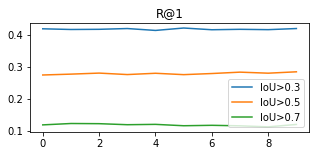

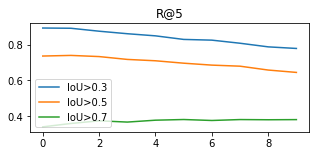

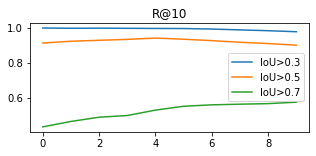

In [22]:
for k in [1,5,10]:
    plt.figure(figsize=(5, 2))
    for thresh in [.3, .5, .7]:
        plt.gca().plot([np.mean(m[f"R@{k} IoU>{thresh}"]) for m in metrics], label=f"IoU>{thresh}")
    plt.title(f"R@{k}")
    plt.legend()
    plt.show()
    plt.close("all")

In [23]:
from src.toolbox.eval import get_first_action, categorize_results, summarize_results_per_class
from src.toolbox.visualization import plot_performance_per_class
import pickle

predictions = predict(segment_generator, test_data, 0.45)
results = evaluate(test_data, predictions)

cat_fn = lambda x: get_first_action(x, segment_generator.vocab)
categorized_results = categorize_results(results, cat_fn)
metrics_per_cls = summarize_results_per_class(categorized_results)

pickle.dump(metrics_per_cls, open("reports/figure_src/metrics_per_cls/charade/action_blind.pkl", "wb"))

class_labels = list(metrics_per_cls.keys())
frequent_class = [label for label in class_labels if len(categorized_results[label]) > 10]
_ = plot_performance_per_class({l: v for l, v in metrics_per_cls.items() if l in frequent_class})

KeyboardInterrupt: 